In [1]:
import pandas as pd
from kmodes.kmodes import KModes
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

In [2]:
df = pd.read_csv('/Users/kevin/Desktop/UNC/academic/Spring2025/STOR 565/Final project/train.csv')
predict = pd.read_csv('/Users/kevin/Desktop/UNC/academic/Spring2025/STOR 565/Final project/test.csv')

In [69]:
from sklearn.utils import resample

df_majority = df[df['Default'] == 0]
df_minority = df[df['Default'] == 1]

df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority)*3,
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Default'].value_counts())

Default
0    88959
1    29653
Name: count, dtype: int64


In [70]:
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
df_balanced[binary_cols] = df_balanced[binary_cols].replace({'Yes': 1, 'No': 0})
predict[binary_cols] = predict[binary_cols].replace({'Yes': 1, 'No': 0})

/var/folders/_3/h5ysk5bd2y35b1ltmqmk472r0000gn/T/ipykernel_73589/3260684534.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_balanced[binary_cols] = df_balanced[binary_cols].replace({'Yes': 1, 'No': 0})


In [31]:
#df_balanced.to_csv('balanced543.csv', index=False, encoding='utf-8')

In [71]:
X = df_balanced.drop(columns=["LoanID", "Default"])
y = df_balanced['Default']
#X = df.drop(columns=["LoanID", "Default"])
#y = df['Default']

In [72]:
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference(categorical_cols)

Logistic Regression

In [73]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [75]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76     22240
           1       0.41      0.69      0.52      7413

    accuracy                           0.68     29653
   macro avg       0.64      0.68      0.64     29653
weighted avg       0.75      0.68      0.70     29653



In [77]:
y_probs_lg = pipeline.predict_proba(X_test)[:, 1]
threshold_lg = 0.5
y_pred_thresh_lg = (y_probs_lg > threshold_lg).astype(int)

In [78]:
repo = classification_report(y_test, y_pred_thresh_lg, output_dict=True)
recall_for_class_1 = repo['1']['recall']
recall_for_class_1

0.687980574666127

In [79]:
logistic_recall_1 = []
logistic_recall_0 = []
for treshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_probs_lg = pipeline.predict_proba(X_test)[:, 1]
    y_pred_thresh_lg = (y_probs_lg > treshold).astype(int)
    logistic_recall_1.append(classification_report(y_test, y_pred_thresh_lg, output_dict=True)['1']['recall'])
    logistic_recall_0.append(classification_report(y_test, y_pred_thresh_lg, output_dict=True)['1']['precision'])


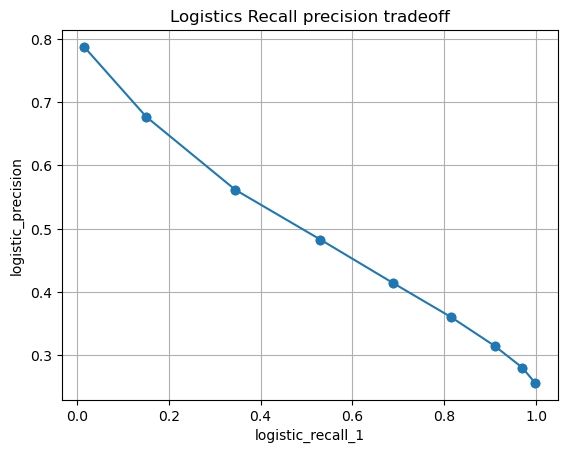

In [80]:
import matplotlib.pyplot as plt
plt.plot(logistic_recall_1, logistic_recall_0, marker='o')
plt.xlabel('logistic_recall_1')
plt.ylabel('logistic_precision')
plt.title('Logistics Recall precision tradeoff')
plt.grid(True)
plt.scatter(logistic_recall_1, logistic_recall_0)
plt.show()

Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

In [82]:
pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'CreditScore', 'DTIRatio', 'HasCoSigner', 'HasDependents',
       'HasMortgage', 'Income', 'InterestRate', 'LoanAmount', 'LoanTerm',
       'MonthsEmployed', 'NumCreditLines'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Education',
                                                   'EmploymentType',
                                                   'MaritalStatus',
                                                   'LoanPurpose'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [83]:
y_pred = pipeline_dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     22240
           1       0.36      0.36      0.36      7413

    accuracy                           0.68     29653
   macro avg       0.58      0.57      0.57     29653
weighted avg       0.68      0.68      0.68     29653



In [84]:
y_probs_dt = pipeline_dt.predict_proba(X_test)[:, 1]
threshold_dt = 0.2
y_pred_thresh_dt = (y_probs_dt > threshold_dt).astype(int)

In [47]:
print(classification_report(y_test, y_pred_thresh_dt))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59      7414
           1       0.59      0.59      0.59      7413

    accuracy                           0.59     14827
   macro avg       0.59      0.59      0.59     14827
weighted avg       0.59      0.59      0.59     14827



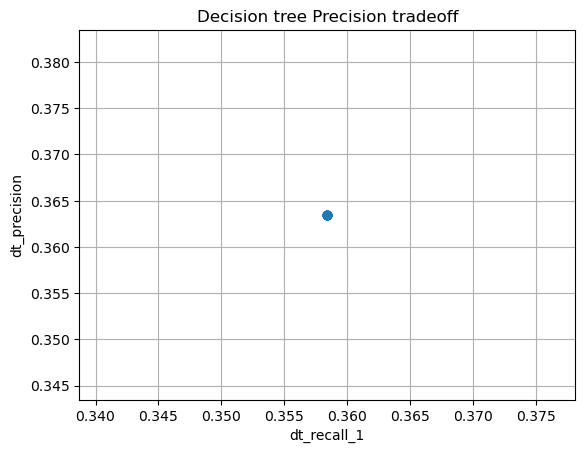

In [85]:
dt_recall_1 = []
dt_recall_0 = []
for treshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_probs_dt = pipeline_dt.predict_proba(X_test)[:, 1]
    y_pred_thresh_dt = (y_probs_dt > treshold).astype(int)
    dt_recall_1.append(classification_report(y_test, y_pred_thresh_dt, output_dict=True)['1']['recall'])
    dt_recall_0.append(classification_report(y_test, y_pred_thresh_dt, output_dict=True)['1']['precision'])

plt.plot(dt_recall_1, dt_recall_0, marker='o')
plt.xlabel('dt_recall_1')
plt.ylabel('dt_precision')
plt.title('Decision tree Precision tradeoff')
plt.grid(True)
plt.scatter(dt_recall_1, dt_recall_0)
plt.show()

Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

In [87]:
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86     22240
           1       0.65      0.17      0.27      7413

    accuracy                           0.77     29653
   macro avg       0.72      0.57      0.57     29653
weighted avg       0.75      0.77      0.71     29653



In [88]:
y_probs = pipeline_rf.predict_proba(X_test)[:, 1]
threshold = 0.25
y_pred_thresh = (y_probs > threshold).astype(int)

In [89]:
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76     22240
           1       0.41      0.67      0.51      7413

    accuracy                           0.68     29653
   macro avg       0.64      0.68      0.64     29653
weighted avg       0.75      0.68      0.70     29653



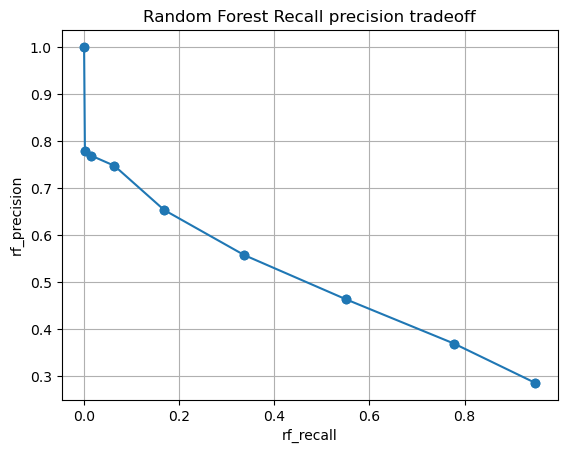

In [90]:
rf_recall_1 = []
rf_recall_0 = []
for treshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_probs_rf = pipeline_rf.predict_proba(X_test)[:, 1]
    y_pred_thresh_rf = (y_probs_rf > treshold).astype(int)
    rf_recall_1.append(classification_report(y_test, y_pred_thresh_rf, output_dict=True)['1']['recall'])
    rf_recall_0.append(classification_report(y_test, y_pred_thresh_rf, output_dict=True)['1']['precision'])

plt.plot(rf_recall_1, rf_recall_0, marker='o')
plt.xlabel('rf_recall')
plt.ylabel('rf_precision')
plt.title('Random Forest Recall precision tradeoff')
plt.grid(True)
plt.scatter(rf_recall_1, rf_recall_0)
plt.show()

In [91]:
feature_names = preprocessor.get_feature_names_out().tolist()

In [ ]:
top_features_df = pd.DataFrame(
    sorted(zip(feature_names, pipeline_rf.named_steps['classifier'].feature_importances_), key=lambda x: x[1], reverse=True),
    columns=["Feature", "Importance"]
)

In [ ]:
top_features_df.head(10)

,Feature,Importance
0,num__Age,0.127038
1,num__InterestRate,0.123840
2,num__Income,0.115933
3,num__LoanAmount,0.102819
4,num__MonthsEmployed,0.097809
5,num__CreditScore,0.087595
6,num__DTIRatio,0.078930
7,num__LoanTerm,0.036723
8,num__NumCreditLines,0.029848
9,num__HasMortgage,0.014113


Logistic Regression with Cross Validation

In [92]:
from sklearn.linear_model import LogisticRegressionCV
pipeline_lrcv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        Cs=10,
        cv=5,
        class_weight='balanced',
        max_iter=1000,
        scoring='f1',
        random_state=42
    ))
])

In [93]:
pipeline_lrcv.fit(X_train, y_train)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86     22240
           1       0.65      0.17      0.27      7413

    accuracy                           0.77     29653
   macro avg       0.72      0.57      0.57     29653
weighted avg       0.75      0.77      0.71     29653



In [94]:
y_probs_lrcv = pipeline_lrcv.predict_proba(X_test)[:, 1]
threshold_lrcv = 0.5
y_pred_lrcv = (y_probs_lrcv > threshold_lrcv).astype(int)

In [95]:
print(classification_report(y_test, y_pred_lrcv))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76     22240
           1       0.41      0.69      0.52      7413

    accuracy                           0.68     29653
   macro avg       0.64      0.68      0.64     29653
weighted avg       0.75      0.68      0.70     29653



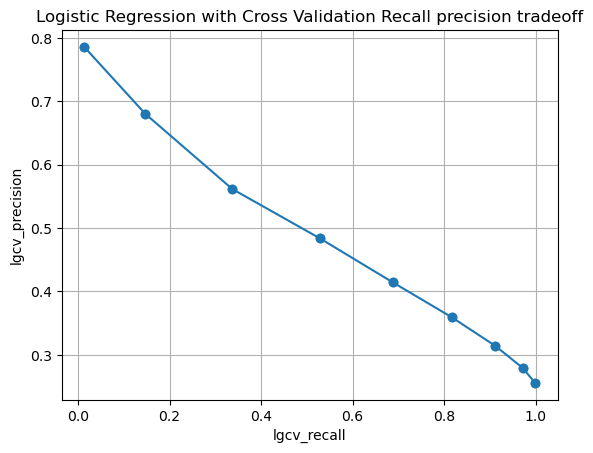

In [96]:
lgcv_recall_1 = []
lgcv_recall_0 = []
for treshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_probs_lgcv = pipeline_lrcv.predict_proba(X_test)[:, 1]
    y_pred_thresh_lgcv = (y_probs_lgcv > treshold).astype(int)
    lgcv_recall_1.append(classification_report(y_test, y_pred_thresh_lgcv, output_dict=True)['1']['recall'])
    lgcv_recall_0.append(classification_report(y_test, y_pred_thresh_lgcv, output_dict=True)['1']['precision'])

plt.plot(lgcv_recall_1, lgcv_recall_0, marker='o')
plt.xlabel('lgcv_recall')
plt.ylabel('lgcv_precision')
plt.title('Logistic Regression with Cross Validation Recall precision tradeoff')
plt.grid(True)
plt.scatter(lgcv_recall_1, lgcv_recall_0)
plt.show()

Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [ ]:
pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', mlp)
])

In [ ]:
pipeline_mlp.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'CreditScore', 'DTIRatio', 'HasCoSigner', 'HasDependents',
       'HasMortgage', 'Income', 'InterestRate', 'LoanAmount', 'LoanTerm',
       'MonthsEmployed', 'NumCreditLines'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Education',
                                                   'EmploymentType',
                                                   'MaritalStatus',
                                                   'LoanPurpose'])])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300,
                               random_state=42))])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86     22240
           1       0.65      0.17      0.27      7413

    accuracy                           0.77     29653
   macro avg       0.72      0.57      0.57     29653
weighted avg       0.75      0.77      0.71     29653



In [ ]:
y_probs_nn = pipeline_mlp.predict_proba(X_test)[:, 1]
threshold_nn = 0.2
y_pred_nn = (y_probs_nn > threshold_nn).astype(int)

In [ ]:
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.85      0.65      0.74     22240
           1       0.39      0.66      0.49      7413

    accuracy                           0.66     29653
   macro avg       0.62      0.66      0.62     29653
weighted avg       0.74      0.66      0.68     29653



Clustering:

In [5]:
top_10_features = [
    'Age', 'InterestRate', 'Income', 'LoanAmount', 'MonthsEmployed', 
    'CreditScore', 'DTIRatio', 'LoanTerm', 'NumCreditLines', 'HasMortgage'
]

In [6]:
data_top_10 = df_balanced[top_10_features]

In [7]:
scaler = StandardScaler()
scaled_data_top_10 = scaler.fit_transform(data_top_10)

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data_top_10)

In [52]:
df_balanced['Cluster'] = clusters

In [53]:
cluster_default_rate = df_balanced.groupby('Cluster')['Default'].mean()
print(cluster_default_rate)

Cluster
0    0.325852
1    0.135304
2    0.303927
Name: Default, dtype: float64


In [ ]:
df_balanced.to_csv('clustered_train.csv', index = False)

In [ ]:
from classtraining543 import DefaultPredictionModel
original_data = pd.read_csv('/Users/kevin/Desktop/UNC/academic/Spring2025/STOR 565/Final project/clustered_train.csv')
model = DefaultPredictionModel(original_data, top_10_features)
model.train_models_per_cluster()

Cluster 0 - Test Accuracy: 0.8091563339980924
Cluster 1 - Test Accuracy: 0.7297054744227788
Cluster 2 - Test Accuracy: 0.7570156846121238


In [10]:
predict.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,7RYZGMKJIR,32,131645,43797,802,23,2,6.10,24,0.13,High School,Full-time,Divorced,1,0,Other,0
1,JDL5RH07AM,61,134312,18402,369,87,2,12.99,60,0.59,High School,Self-employed,Single,0,0,Business,1
2,STAL716Y79,55,115809,151774,563,3,3,5.51,48,0.82,Bachelor's,Full-time,Single,1,1,Other,1
3,SO0KKJ3IQB,58,94970,55789,337,24,1,23.93,36,0.77,Bachelor's,Unemployed,Divorced,0,0,Business,0
4,T99CWTYDCP,63,71727,189798,451,52,3,22.05,48,0.44,PhD,Unemployed,Single,1,0,Auto,0


In [ ]:

predicted_df = model.predict_for_new_data(predict)

print(predicted_df.head())

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid fea

KeyboardInterrupt: 

In [ ]:
def predict_clusters_for_testing_set(original_data, top_10_features):
    

    kmeans = KMeans(n_clusters=3, random_state=42)

    scaler = StandardScaler()
    scaled_data_top_10_orig = scaler.fit_transform(original_data[top_10_features])

    cluster = kmeans.fit(scaled_data_top_10_orig)

    original_data['Cluster'] = cluster

    original_data.to_csv('training_data_with_predicted_clusters.csv', index = False)
    '''
    # Predict the cluster for each row in the new dataset
    scaler = StandardScaler()
    scaled_data_top_10_pred = scaler.fit_transform(new_data[top_10_features])

    predicted_clusters = kmeans.predict(scaled_data_top_10_pred)
    
    # Add the predicted cluster labels to the new dataset
    new_data['PredictedCluster'] = predicted_clusters
    
    # Save the new dataset with the predicted clusters
    new_data.to_csv('testing_data_with_predicted_clusters.csv', index=False)
    #print("Predicted clusters saved to 'testing_data_with_predicted_clusters.csv'")
    '''

In [ ]:
from classtraining543 import DefaultPredictionModel
from sklearn.cluster import KMeans
original_data = pd.read_csv('')

model = DefaultPredictionModel(original_data, top_10_features)

predict_clusters_for_testing_set(df_balanced, top_10_features)

model.train_models_per_cluster()

predicted_df = model.predict_for_new_data(predict)

print(predicted_df.head())

FileNotFoundError: [Errno 2] No such file or directory: ''